Accesible en https://colab.research.google.com/drive/1QetbZdXGZ9pqxMAXkM8GJ_K2pLztK-Rl?usp=sharing

https://bit.ly/3x71MWH

#Minimax
El algoritmo minimax, a traves de enumeraciones de todas las jugadas posibles, maximiza la utilidad para el mismo, mientras que supone que el contrincante siempre juega a minimizar la utilidad.

La utilidad es una función que determina el puntaje. 

En el algoritmo minimax, la búsqueda se ejecuta en profundidad, y al llegar al encontrar un estado terminal (un estado donde el juego termina) devuelve la utilidad de dicho estado mientras las llamadas recursivas van terminando.


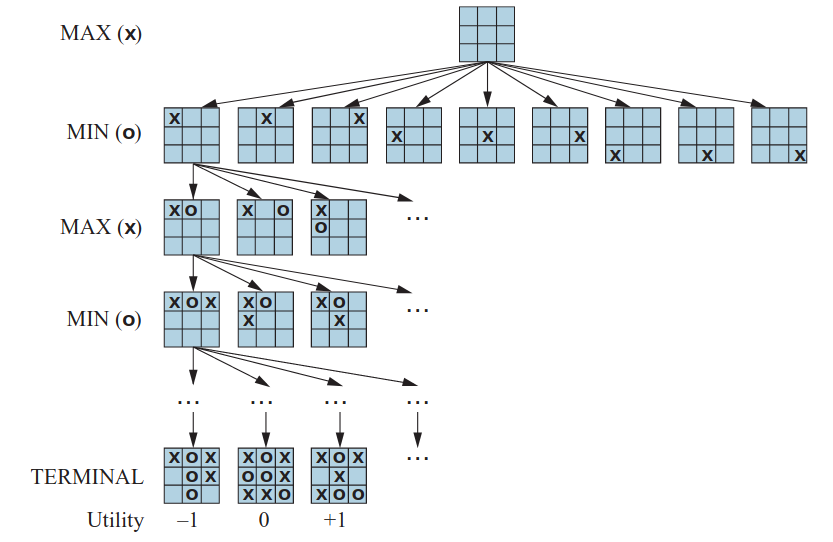

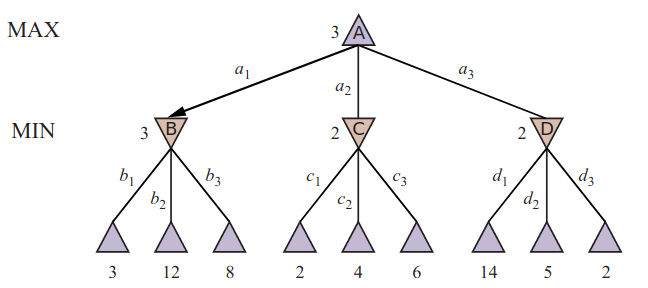

#Pseudocodigo (Russell and Norvig)
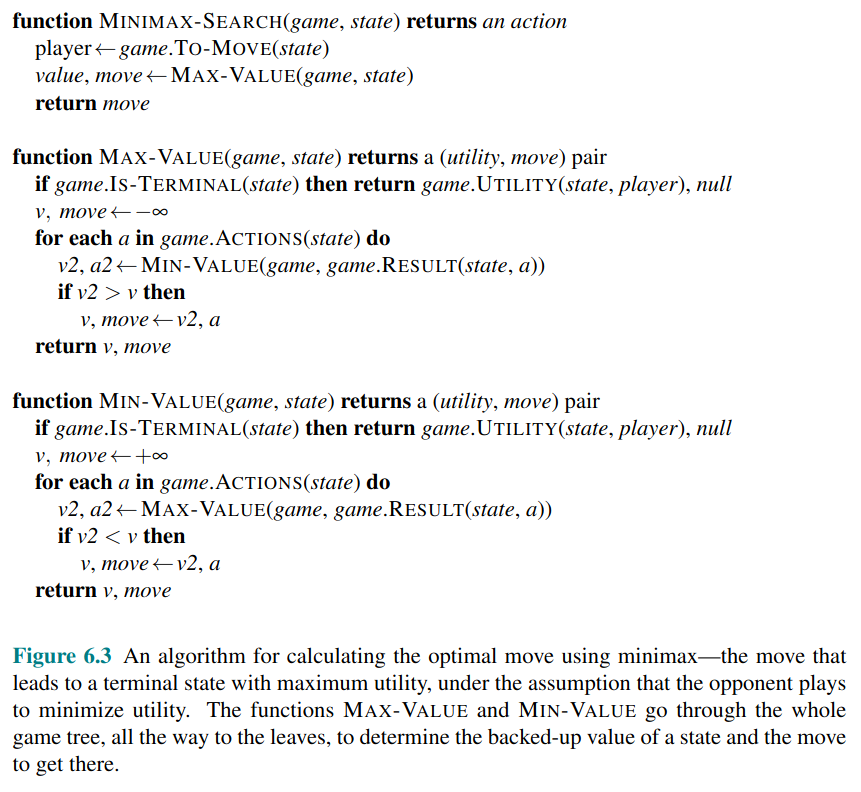

#Pseudocodigo (Edelkamp and Schordl)
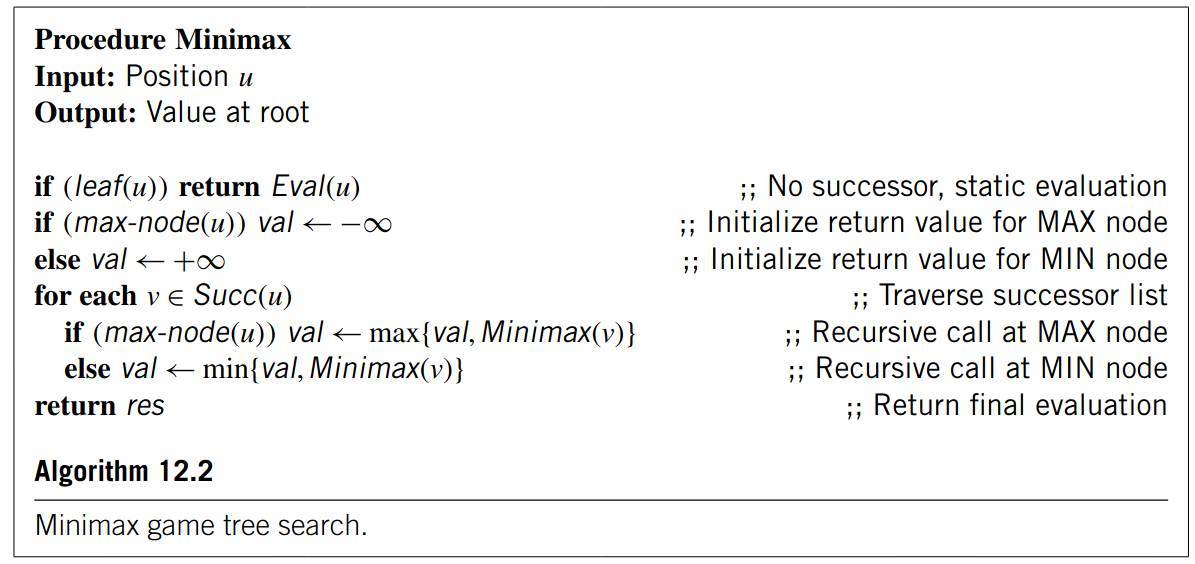

# Juego del gato

Vamos a programar el juego del gato

# GAME

La clase game es una clase abstracta que describe los métodos que debe incorporar el juego. 

In [1]:
from collections import namedtuple, Counter, defaultdict
import random
import math
import functools 
infinity = math.inf
cache = functools.lru_cache(10**6)

class Game:
    def actions(self, state):
        raise NotImplementedError

    def result(self, state, move):
        raise NotImplementedError

    def is_terminal(self, state):
        return not self.actions(state)
    
    def utility(self, state, player):
        raise NotImplementedError


Un objeto de la clase board corresponde a un tablero de juego.

In [2]:
class Board(defaultdict):
    """A board has the player to move, a cached utility value, 
    and a dict of {(x, y): player} entries, where player is 'X' or 'O'."""
    empty = '.'
    off = '#'
    
    def __init__(self, width=8, height=8, to_move=None, **kwds):
        self.__dict__.update(width=width, height=height, to_move=to_move, **kwds)
        
    def new(self, changes: dict, **kwds) -> 'Board':
        "Given a dict of {(x, y): contents} changes, return a new Board with the changes."
        board = Board(width=self.width, height=self.height, **kwds)
        board.update(self)
        board.update(changes)
        return board

    def __missing__(self, loc):
        x, y = loc
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.empty
        else:
            return self.off
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)
    
    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(map(row, range(self.height))) +  '\n'


# Clase Gato
La clase gato hereda de la clase Game e implementa los métodos descritos anteriormente:
- Actions: retorna las jugadas válidas para el jugador
- result: Actualiza el tablero una vez hecha una jugada
- Utility: Es la función de utilidad. En este caso es 1 cuando X gana, -1 cuando X pierde (gana O), y 0 cuando empata.
- is_terminal: Retorna true si es un estado terminal.

In [3]:
class Gato(Game):
    """Play TicTacToe on an `height` by `width` board, needing `k` in a row to win.
    'X' plays first against 'O'."""

    def __init__(self, height=3, width=3, k=3):
        self.k = k # k in a row
        self.squares = {(x, y) for x in range(width) for y in range(height)}
        self.initial = Board(height=height, width=width, to_move='X', utility=0)

    def actions(self, board):
        """Legal moves are any square not yet taken."""
        return self.squares - set(board)

    def result(self, board, square):
        """Place a marker for current player on square."""
        player = board.to_move
        board = board.new({square: player}, to_move=('O' if player == 'X' else 'X'))
        win = k_in_row(board, player, square, self.k)
        board.utility = (0 if not win else +1 if player == 'X' else -1)
        return board

    def utility(self, board, player):
        """Return the value to player; 1 for win, -1 for loss, 0 otherwise."""
        return board.utility if player == 'X' else -board.utility

    def is_terminal(self, board):
        """A board is a terminal state if it is won or there are no empty squares."""
        return board.utility != 0 or len(self.squares) == len(board)

    def display(self, board): print(board)     


def k_in_row(board, player, square, k):
    """True if player has k pieces in a line through square."""
    def in_row(x, y, dx, dy): return 0 if board[x, y] != player else 1 + in_row(x + dx, y + dy, dx, dy)
    return any(in_row(*square, dx, dy) + in_row(*square, -dx, -dy) - 1 >= k
               for (dx, dy) in ((0, 1), (1, 0), (1, 1), (1, -1)))


In [13]:
expansiones = 0
def minimax_search(game, state):
    """Search game tree to determine best move; return (value, move) pair."""

    player = state.to_move

    def max_value(state):
        global expansiones 
        expansiones += 1
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a))
            if v2 > v:
                v, move = v2, a
        return v, move

    def min_value(state):
        global expansiones 
        expansiones += 1
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a))
            if v2 < v:
                v, move = v2, a
        return v, move

    return max_value(state)

In [14]:
def play_game(game, strategies: dict, verbose=False):
    """Play a turn-taking game. `strategies` is a {player_name: function} dict,
    where function(state, game) is used to get the player's move."""
    state = game.initial
    while not game.is_terminal(state):
        player = state.to_move
        move = strategies[player](game, state)
        state = game.result(state, move)
        if verbose: 
            print('Player', player, 'move:', move, 'expansions:', expansiones)
            print(state)
    return state

def random_player(game, state): return random.choice(list(game.actions(state)))

def player(search_algorithm):
    """A game player who uses the specified search algorithm"""
    return lambda game, state: search_algorithm(game, state)[1]

In [15]:
play_game(Gato(), dict(X=player(minimax_search), O=random_player), verbose=True).utility

Player X move: (0, 1) expansions: 549946
. . .
X . .
. . .

Player O move: (2, 1) expansions: 549946
. . .
X . O
. . .

Player X move: (1, 2) expansions: 559346
. . .
X . O
. X .

Player O move: (1, 1) expansions: 559346
. . .
X O O
. X .

Player X move: (0, 2) expansions: 559592
. . .
X O O
X X .

Player O move: (2, 2) expansions: 559592
. . .
X O O
X X O

Player X move: (0, 0) expansions: 559601
X . .
X O O
X X O



1

# Alpha-Beta prunning
- Alpha: El mejor valor para max
- Beta: El mejor valor para min

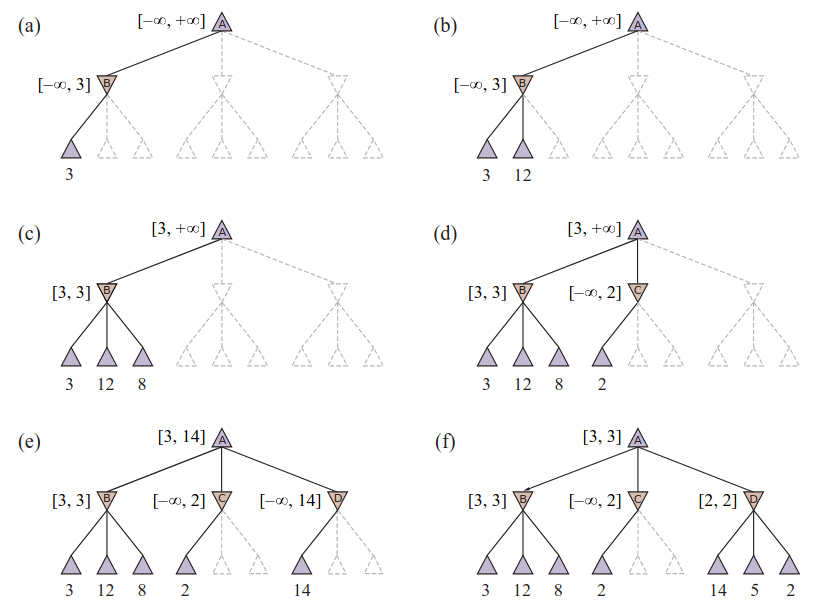

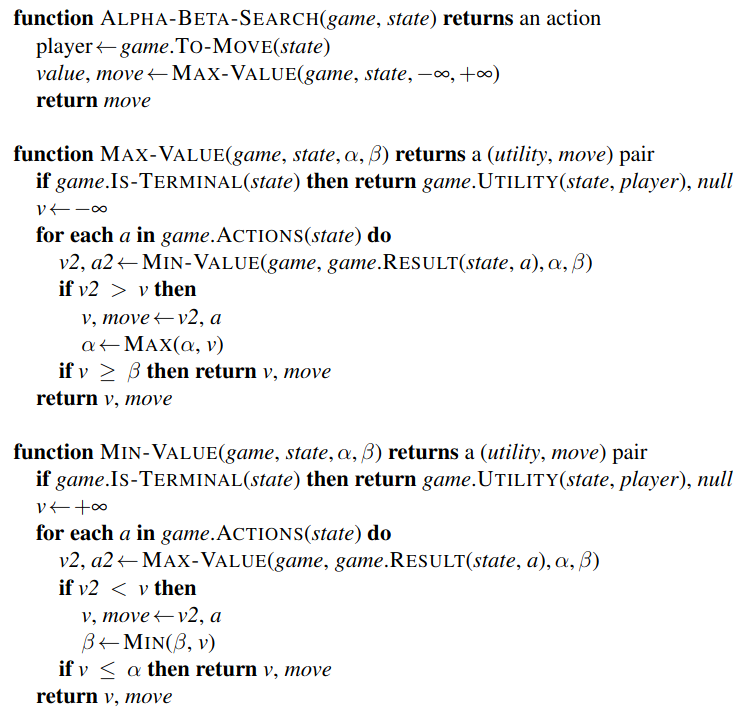

In [11]:
expansiones = 0
def alphabeta_search(game, state):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = state.to_move

    def max_value(state, alpha, beta):
        global expansiones 
        expansiones += 1
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    def min_value(state, alpha, beta):
        global expansiones 
        expansiones += 1
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -infinity, +infinity)

In [12]:
play_game(Gato(), dict(X=random_player, O=player(alphabeta_search)), verbose=True).utility

Player X move: (1, 2) expansions: 0
. . .
. . .
. X .

Player O move: (1, 1) expansions: 6904
. . .
. O .
. X .

Player X move: (1, 0) expansions: 6904
. X .
. O .
. X .

Player O move: (0, 1) expansions: 7083
. X .
O O .
. X .

Player X move: (2, 1) expansions: 7083
. X .
O O X
. X .

Player O move: (0, 0) expansions: 7120
O X .
O O X
. X .

Player X move: (0, 2) expansions: 7120
O X .
O O X
X X .

Player O move: (2, 2) expansions: 7124
O X .
O O X
X X O



-1